In [1]:
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
sys.path.append('../../src')
from Library import VerboseLibrary
from ActivityClassifier import PatientTrendAwareThresholder
import matplotlib.colors as mcolors

named_colors = list(mcolors.TABLEAU_COLORS)

device = 'cpu'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Models

In [2]:
model_names = sorted(os.listdir('./models_no_thresholding'))
len(model_names)

10

In [3]:
model_coefficient_history = {}
model_coefficient_mask = {}
model_coefficients = {}

for name in tqdm(model_names):
    model = torch.load(os.path.join('.', 'models_no_thresholding', name)).to(device)
    model_coefficient_history[name] = np.array(model.coefficient_history)
    model_coefficients[name] = np.array(model.coefficient_mask.detach().cpu().numpy() * model.coefficients.detach().cpu().numpy())
    model_coefficient_mask[name] = np.array(model.coefficient_mask)

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


# Coefficients

In [4]:
masked_coefficient_list = np.array([model_coefficients[name].round(2) for name in model_names], dtype=object)

In [5]:
masked_coefficient_list[masked_coefficient_list == 0] = '-'

In [6]:
pd.DataFrame(masked_coefficient_list[:, :, 0], columns=['*'.join(l) for l in VerboseLibrary(model.library).build_verbose()])

1   z_1   z_2 z_1*z_1 z_1*z_2 z_2*z_2 z_1*z_1*z_1 z_1*z_1*z_2  \
0  0.02 -0.05 -0.46    0.01    0.01   -0.01        0.04         0.1   
1 -0.02 -0.09 -0.28    0.01   -0.02   -0.02       -0.11        0.37   
2     -  0.05  0.87    0.01   -0.02    0.02           -       -0.21   
3  0.06 -0.03 -0.04    0.02    0.01    0.08        0.05        0.02   
4 -0.05 -0.02 -0.37       -       -    0.01       -0.01        0.03   
5  0.01  0.02  0.88    0.03   -0.03       -        0.03       -0.13   
6  0.08  0.03  0.93    0.01    0.01    0.03       -0.04       -0.15   
7 -0.05 -0.03 -0.49   -0.01   -0.04   -0.01        0.03        0.05   
8 -0.01 -0.06 -0.44   -0.01       -   -0.01        0.07        0.07   
9 -0.02     -  0.93   -0.01   -0.01   -0.01       -0.04       -0.15   

  z_1*z_2*z_2 z_2*z_2*z_2 sin(z_1) sin(z_2)  
0       -0.05       -0.07    -0.05    -0.59  
1        0.02       -0.23    -0.08    -0.74  
2        0.03        0.08     0.05    -0.01  
3           -        0.01    -0.04     0.11  
4       -0.02           -    -0.02    -0.67  
5       -0.04       -0.02     0.01     0.02  
6        0.03           -     0.04     0.08  
7       -0.06           -    -0.03    -0.53  
8       -0.09       -0.01    -0.07     -0.5  
9           -        0.05     0.01     0.05

In [7]:
pd.DataFrame(masked_coefficient_list[:, :, 1], columns=['*'.join(l) for l in VerboseLibrary(model.library).build_verbose()])

1   z_1   z_2 z_1*z_1 z_1*z_2 z_2*z_2 z_1*z_1*z_1 z_1*z_1*z_2  \
0  0.07  0.85  0.03    0.05    0.03       -        0.09           -   
1 -0.01  0.87   0.1   -0.01   -0.02       -        0.15        0.15   
2 -0.05 -0.36 -0.05   -0.02   -0.01   -0.03       -0.01       -0.02   
3 -0.02 -0.03  0.01    0.02    0.02   -0.01        0.07       -0.01   
4  0.03  0.87  0.03       -    0.01       -       -0.07        0.08   
5 -0.13 -0.93 -0.02   -0.02   -0.02   -0.05        0.06       -0.04   
6 -0.01 -0.36 -0.02       -       -       -        0.01           -   
7  0.12  0.89  0.01    0.05    0.01    0.05        0.02       -0.07   
8 -0.02  0.91  0.05       -       -       -        0.11       -0.05   
9 -0.02 -0.38     -       -       -       -        0.01       -0.02   

  z_1*z_2*z_2 z_2*z_2*z_2 sin(z_1) sin(z_2)  
0       -0.24       -0.01    -0.03     0.04  
1       -0.28       -0.07    -0.02     0.11  
2        0.06       -0.01     -0.7    -0.05  
3       -0.02           -    -0.04    -0.01  
4       -0.04       -0.06     0.05     0.04  
5       -0.05           -    -0.13    -0.02  
6        0.02        0.01    -0.64    -0.03  
7       -0.11        0.07     0.04        -  
8       -0.21        0.05     0.01     0.04  
9        0.05        0.05    -0.54    -0.01

# Execute

In [8]:
threshold_trial_epochs = np.arange(0, 3002, 500)

In [9]:
def actual_coefficient_survived(name, i, dim):
    return (np.abs(model_coefficient_history[name][threshold_trial_epochs, i, dim]) >= 0.1).all()

def coefficient_survived(name, i, dim, genuine=False):
    if not genuine:
        return np.logical_not(model_classified_history[name][:3001, i, dim]).all()
    else:
        return np.logical_not(model_classified_history[name][:3001, i, dim]).all() and np.abs(model_coefficients[name][i, dim]) >= 0.1

In [10]:
model_linear_detected = {
    name: np.array([np.array([actual_coefficient_survived(name, i, j) for i in [1, 2]]).any() for j in range(2)]) for name in model_names}
model_any_detected = {
    name: np.array([
        np.array([actual_coefficient_survived(name, i, j) for i in range(12)]).any()
        and not model_linear_detected[name][j]
        for j in range(2)])
    for name in model_names}
model_none_detected = {
    name: np.array([
        not model_linear_detected[name][j] and not model_any_detected[name][j]
        for j in range(2)])
    for name in model_names}

In [11]:
for name in model_names:
    print([model_linear_detected[name], model_any_detected[name], model_none_detected[name]])

[array([False,  True]), array([ True, False]), array([False, False])]
[array([False,  True]), array([ True, False]), array([False, False])]
[array([ True, False]), array([False,  True]), array([False, False])]
[array([False, False]), array([False, False]), array([ True,  True])]
[array([False,  True]), array([False, False]), array([ True, False])]
[array([ True, False]), array([False, False]), array([False,  True])]
[array([ True, False]), array([False,  True]), array([False, False])]
[array([False,  True]), array([ True, False]), array([False, False])]
[array([False,  True]), array([False, False]), array([ True, False])]
[array([ True, False]), array([False,  True]), array([False, False])]


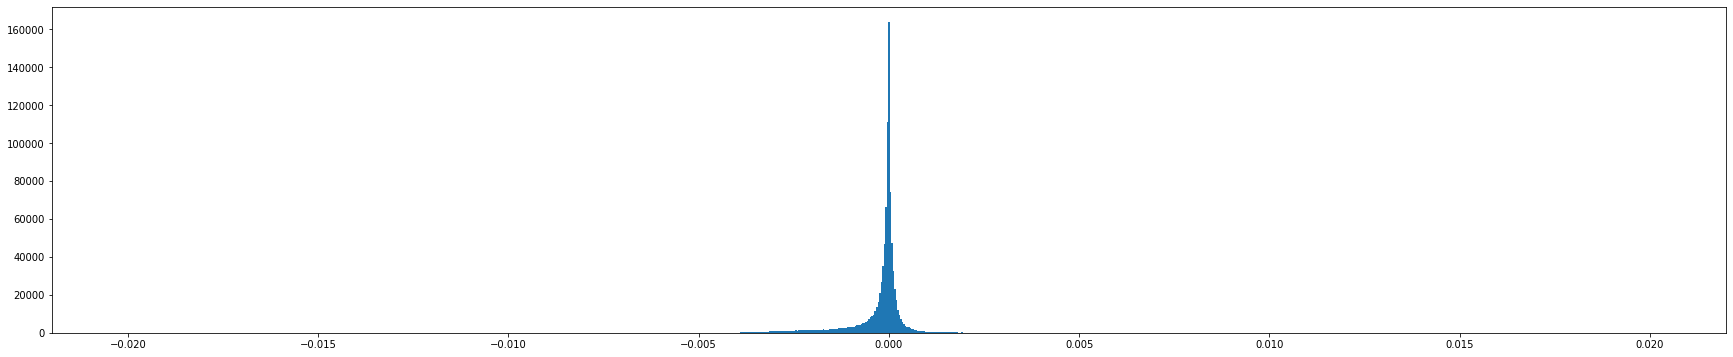

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
ax.hist(np.stack([np.diff(model_coefficient_history[name], axis=0) for name in model_names]).flatten(), bins=np.linspace(-0.02, 0.02, 1000));

In [13]:
trend_std = 2 * np.stack([model_coefficient_history[name] for name in model_names]).flatten().std()
trend_std.round(4)

0.9515

In [14]:
trend_std = 2 * np.stack([np.diff(model_coefficient_history[name], axis=0) for name in model_names]).flatten().std()
trend_std.round(4)

0.0017

In [15]:
cc = PatientTrendAwareThresholder()

In [16]:
model_classified_history = {}
model_classified_plus_history = {}

for name in tqdm(model_names):
    model_classified_history[name] = np.stack([cc.classify_converged(model_coefficient_history[name][:i])[0] for i in range(1, len(model_coefficient_history[name]))])

100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


In [17]:
model_ptat_linear_detected = {
    name: np.array([np.array([coefficient_survived(name, i, j) for i in [1, 2]]).any() for j in range(2)]) for name in model_names}
model_ptat_any_detected = {
    name: np.array([
        np.array([coefficient_survived(name, i, j) for i in range(12)]).any()
        and not model_ptat_linear_detected[name][j]
        for j in range(2)])
    for name in model_names}
model_ptat_none_detected = {
    name: np.array([not model_ptat_linear_detected[name][j] and not model_ptat_any_detected[name][j] for j in range(2)])
    for name in model_names}

model_genuine_ptat_linear_detected = {
    name: np.array([np.array([coefficient_survived(name, i, j, True) for i in [1, 2]]).any() for j in range(2)]) for name in model_names}
model_genuine_ptat_any_detected = {
    name: np.array([
        np.array([coefficient_survived(name, i, j, True) for i in range(12)]).any()
        and not model_genuine_ptat_linear_detected[name][j]
        for j in range(2)])
    for name in model_names}
model_genuine_ptat_none_detected = {
    name: np.array([not model_genuine_ptat_linear_detected[name][j] and not model_genuine_ptat_any_detected[name][j] for j in range(2)])
    for name in model_names}

In [18]:
# with non-genuine
np.sum([model_ptat_linear_detected[name] for name in model_names]), np.sum([model_ptat_any_detected[name] for name in model_names]), np.sum([model_ptat_none_detected[name] for name in model_names])

(18, 2, 0)

In [19]:
# without non-genuine
np.sum([model_genuine_ptat_linear_detected[name] for name in model_names]), np.sum([model_genuine_ptat_any_detected[name] for name in model_names]), np.sum([model_genuine_ptat_none_detected[name] for name in model_names])

(18, 0, 2)

In [20]:
total_terms_detected = {name: np.sum(np.logical_not(model_classified_history[name][:3001, :, 0]).all(axis=0)) for name in model_names}
total_true_terms_detected = {name: np.sum(np.logical_and(np.abs(model_coefficient_history[name][3001, :, 0]) >= 0.1, np.logical_not(model_classified_history[name][:3001, :, 0]).all(axis=0))) for name in model_names}

In [21]:
np.mean([v for v in total_terms_detected.values()]), np.mean([v for v in total_true_terms_detected.values()])

(5.1, 1.4)

In [22]:
for name in model_names:
    print([model_ptat_linear_detected[name], model_ptat_any_detected[name], model_ptat_none_detected[name]])

[array([ True,  True]), array([False, False]), array([False, False])]
[array([ True,  True]), array([False, False]), array([False, False])]
[array([ True,  True]), array([False, False]), array([False, False])]
[array([False, False]), array([ True,  True]), array([False, False])]
[array([ True,  True]), array([False, False]), array([False, False])]
[array([ True,  True]), array([False, False]), array([False, False])]
[array([ True,  True]), array([False, False]), array([False, False])]
[array([ True,  True]), array([False, False]), array([False, False])]
[array([ True,  True]), array([False, False]), array([False, False])]
[array([ True,  True]), array([False, False]), array([False, False])]


# History

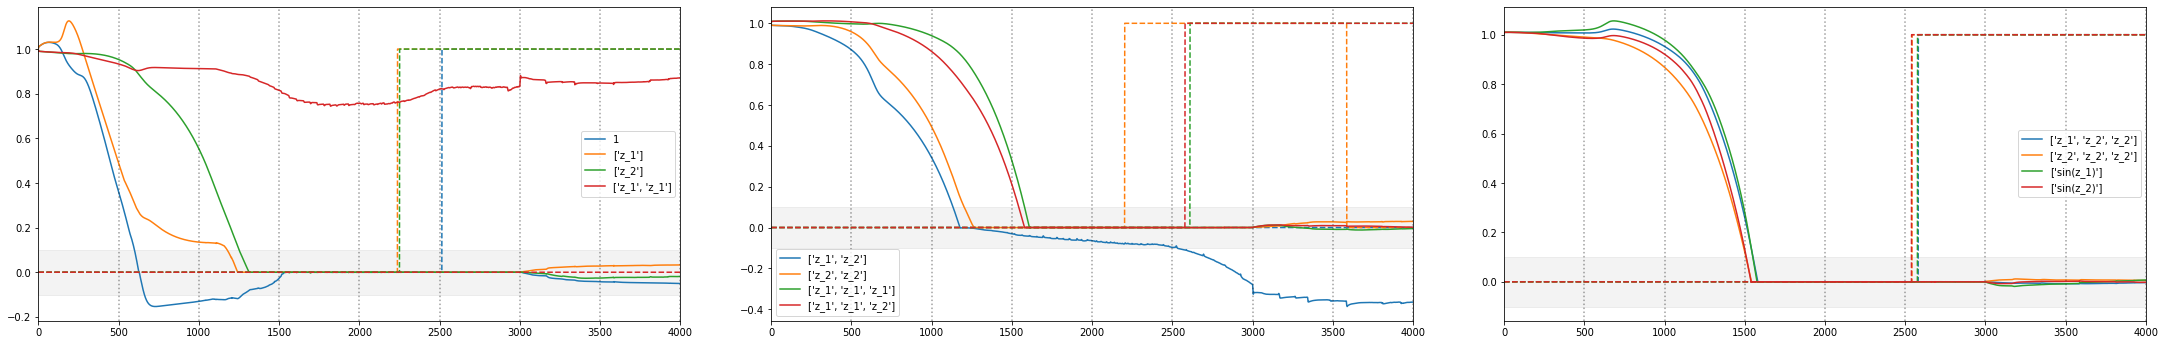

In [23]:
m = model_names[4]
xlim = 4001

fig, ax = plt.subplots(1, 3, figsize=(30, 5))
fig.tight_layout(w_pad=6, h_pad=5)
plt.subplots_adjust(top=0.95)

for split in range(3):
    for i, (n, c, r) in enumerate(
        zip(VerboseLibrary(model.library).build_verbose()[split*4:(split+1)*4],
        model_coefficient_history[m].reshape(4002, 24).T[split*4:(split+1)*4],
        model_classified_history[m].reshape(4001, 24).T[split*4:(split+1)*4],
        )):
        ax[split].plot(c[:xlim].T, label=n, color=named_colors[i])
        ax[split].plot(r[:xlim].T, color=named_colors[i], linestyle='--')
        ax[split].legend(); ax[split].axhspan(-0.1, 0.1, color='black', alpha=0.01); ax[split].set_xlim(0, xlim);# ax[split].set_ylim(-0.1, 0.1)
        for threshold_epoch in np.arange(500, xlim, 500): ax[split].axvline(threshold_epoch, color='black', alpha=0.1, linestyle=':')

# Histories with Thresholding in Epoch 500

100%|██████████| 10/10 [00:00<00:00, 102.93it/s]


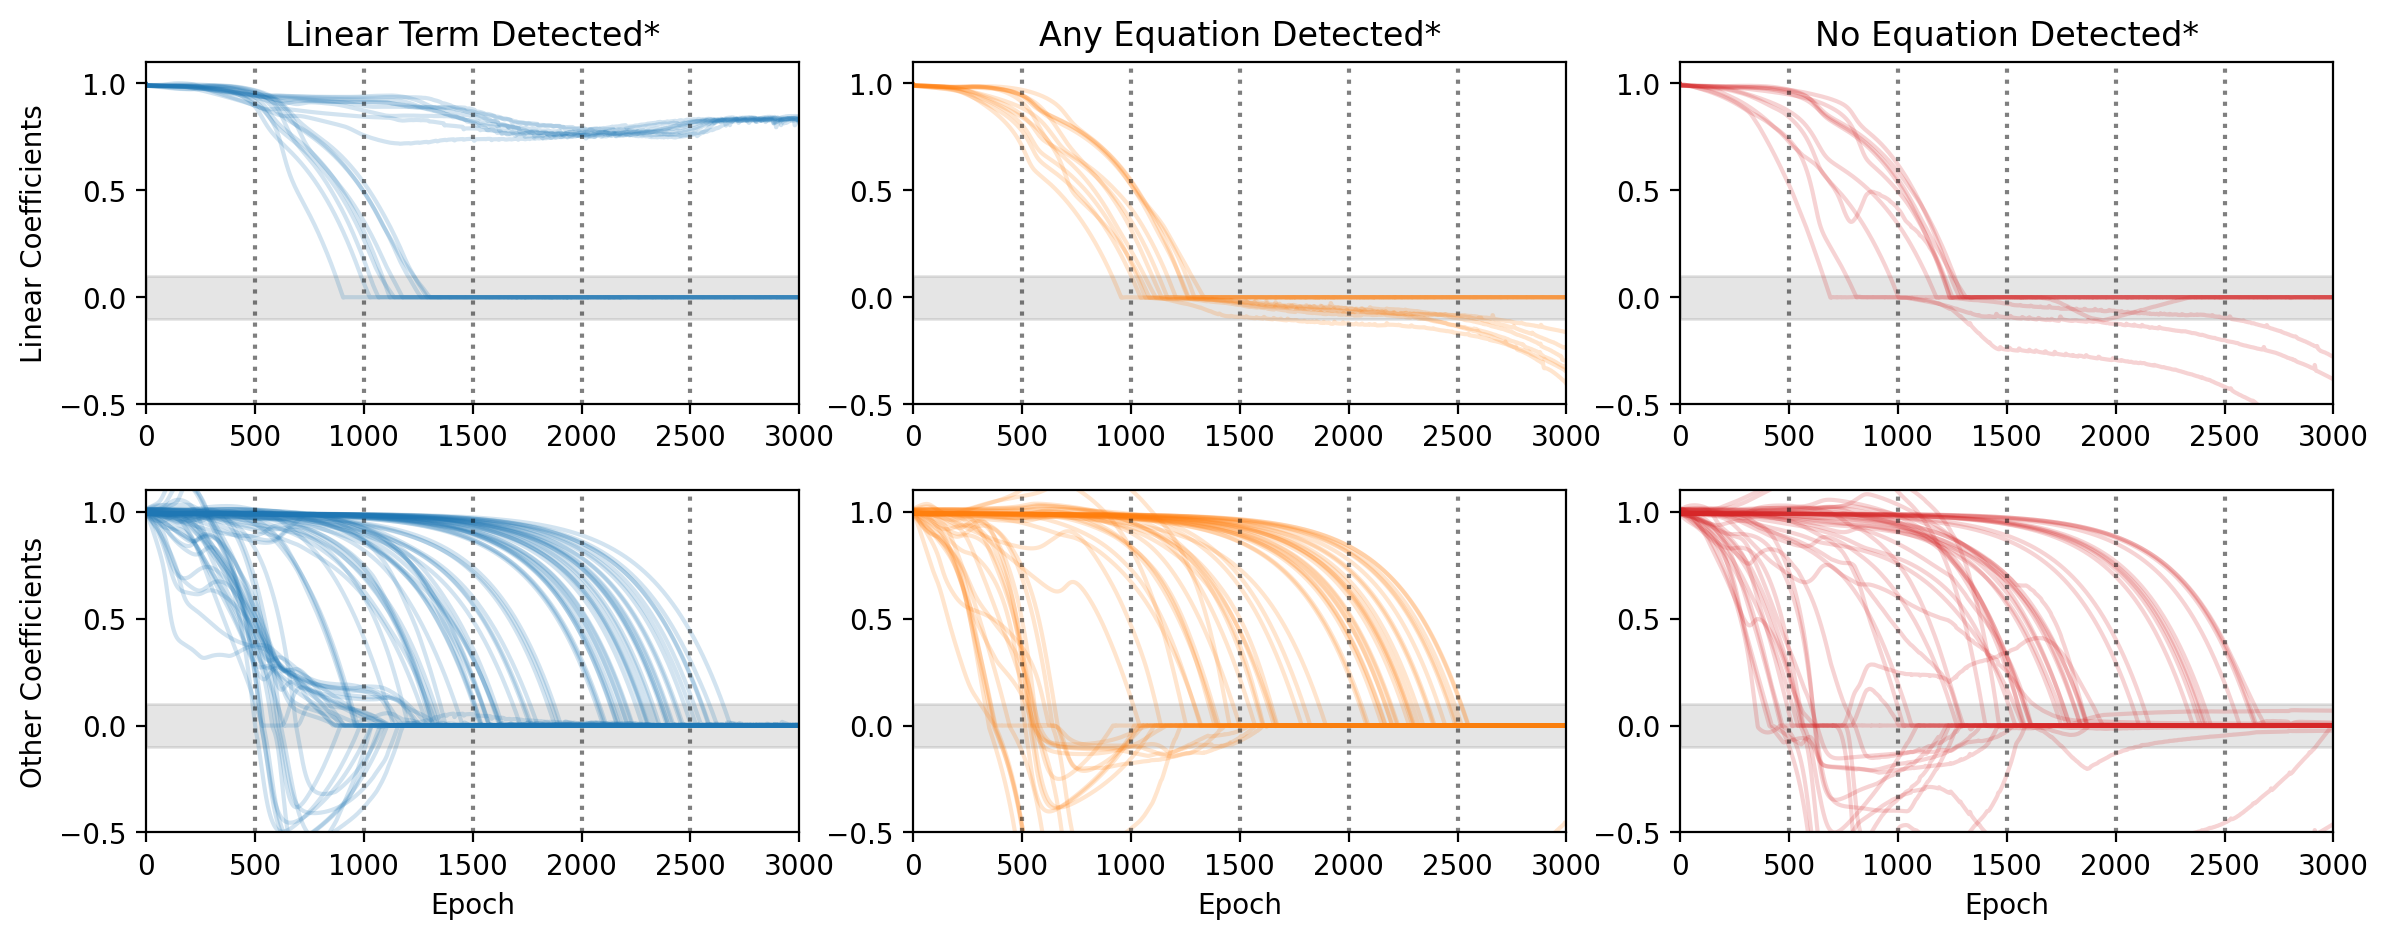

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(21/1.8, 8/1.8), dpi=200)
fig.tight_layout(w_pad=1, h_pad=1)
xlim = 3000
alpha=0.2

for name in tqdm(model_names):
    for j in range(2):
        if model_linear_detected[name][j]:
            axes[0][0].plot(model_coefficient_history[name][:xlim, 1:3, j].reshape(xlim, -1), color='tab:blue', alpha=alpha);
            axes[1][0].plot(model_coefficient_history[name][:xlim, 0, j].reshape(xlim, -1), color='tab:blue', alpha=alpha);
            axes[1][0].plot(model_coefficient_history[name][:xlim, 3:, j].reshape(xlim, -1), color='tab:blue', alpha=alpha);
        if model_any_detected[name][j]:
            axes[0][1].plot(model_coefficient_history[name][:xlim, 1:3, j].reshape(xlim, -1), color='tab:orange', alpha=alpha);
            axes[1][1].plot(model_coefficient_history[name][:xlim, 0, j].reshape(xlim, -1), color='tab:orange', alpha=alpha);
            axes[1][1].plot(model_coefficient_history[name][:xlim, 3:, j].reshape(xlim, -1), color='tab:orange', alpha=alpha);
        if model_none_detected[name][j]:
            axes[0][2].plot(model_coefficient_history[name][:xlim, 1:3, j].reshape(xlim, -1), color='tab:red', alpha=alpha);
            axes[1][2].plot(model_coefficient_history[name][:xlim, 0, j].reshape(xlim, -1), color='tab:red', alpha=alpha);
            axes[1][2].plot(model_coefficient_history[name][:xlim, 3:, j].reshape(xlim, -1), color='tab:red', alpha=alpha);

axes[0][0].set_title(f'Linear Term Detected*');
axes[0][1].set_title(f'Any Equation Detected*');
axes[0][2].set_title(f'No Equation Detected*');

axes[0][0].set_ylabel('Linear Coefficients');
axes[1][0].set_ylabel('Other Coefficients');

for ax in axes[0]:
    ax.set_xlim(0, xlim); ax.axhspan(-0.1, 0.1, color='black', alpha=0.1);
    for threshold_epoch in np.arange(500, xlim, 500): ax.axvline(threshold_epoch, color='black', alpha=0.5, linestyle=':'); ax.set_ylim(-0.5, 1.1)
    #ax.axvline(3000, color='black', linestyle='--');

for ax in axes[1]:
    ax.set_xlabel('Epoch');ax.set_xlim(0, xlim); ax.axhspan(-0.1, 0.1, color='black', alpha=0.1);
    for threshold_epoch in np.arange(500, xlim, 500): ax.axvline(threshold_epoch, color='black', alpha=0.5, linestyle=':'); ax.set_ylim(-0.5, 1.1)
    #ax.axvline(3000, color='black', linestyle='--');

In [21]:
confusion_matrix = np.zeros((3, 3))

for j in range(2):
    for name in model_names:
        # model_only_lin_detected[name], 
        # model_only_sin_detected[name], model_sin_lin_detected[name], model_any_detected[name], model_none_detected[name]
        confusion_matrix[
            int(model_ptat_any_detected[name][j]) + 2 * int(model_ptat_none_detected[name][j]),
            int(model_any_detected[name][j]) + 2 * int(model_none_detected[name][j])
        ] += 1

pd.DataFrame(confusion_matrix, columns=['ST linear', 'ST any', 'ST none'], index=['PTAT linear', 'PTAT any', 'PTAT none'], dtype=int)

ST linear  ST any  ST none
PTAT linear          9       6        3
PTAT any             0       0        2
PTAT none            0       0        0